In [1]:
import datetime
import numpy as np 
import time
import re
from datetime import datetime
import pickle
import string
import pandas as pd
from copy import deepcopy
import operator
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import urllib.request
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# aux functions

In [3]:
def get_pe_ratio(soup_tag):
    
    pe_ratio = float(str(soup_tag[0]).split("<")[1].split(">")[-1])
    print("P/E ratio", pe_ratio)
    
    return pe_ratio
    
def get_short_float(soup_tag):
    
    short_float = float(str(soup_tag[-1]).split("<")[1].split(">")[-1][:-1])
    print("Short interest", short_float)
    
    return short_float

def get_prices(list_tag):
    
    current = float(".".join(re.findall(r'\d+', str(list_tag[-1]))))
    median_estimate = float(".".join(re.findall(r'\d+', str(list_tag[-4]))))
    low_estimate = float(".".join(re.findall(r'\d+', str(list_tag[-3]))))
    high_estimate = float(".".join(re.findall(r'\d+', str(list_tag[-5]))))
    
    median_change = ((median_estimate-current)/current)*100
    high_change = ((high_estimate-current)/current)*100
    low_change = ((low_estimate-current)/current)*100
    
    return median_change, high_change, low_change, current

def get_num_analysts(list_tag):
    
    num_analyst_list = list_tag[7:-5]
    num_analyst_list = [num_analyst_list[2+index*3] for index in range(int(len(num_analyst_list)/3))]
    n_analysts = np.sum([int(re.findall(r'\d+', str(string_analyst))[0]) for string_analyst in num_analyst_list])

    return n_analysts

def get_industry(soup_tag):
    
    industry = str(soup_tag[1]).split(",")[5].split("\"")[3]
    
    return industry
    

# fetch company names and price

In [4]:
def get_nyse_stocks():
    
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:63.0) Gecko/20100101 Firefox/63.0'}

    list_stock = []
    for letter in string.ascii_uppercase:
        print("Fetching for letter: " + letter)
        
        r = requests.get("https://eoddata.com/stocklist/NYSE/" + letter + ".htm", headers=headers)
        html_doc = r.text
        soup = BeautifulSoup(html_doc, 'html.parser')
        soup_tag = soup.find_all("a", href=True)

        for link in soup_tag:
            text = link.get('href')
            if "/stockquote/NYSE/" in text:
                text = text.split("/")[-1].split(".")[0]

                if text not in list_stock:
                    list_stock.append(text)
                    
    return list_stock

In [5]:
def get_interesting_stocks(list_stock):
    
    interesting_stocks = dict()
    database = dict()
    
    for symbol in list_stock:
        
        print(symbol)

        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:63.0) Gecko/20100101 Firefox/63.0'}
        
        full_data = True
        try:
            r = requests.get("https://www.wsj.com/market-data/quotes/" + symbol + "/research-ratings", headers=headers)
            html_doc = r.text
            soup = BeautifulSoup(html_doc, 'html.parser')
            soup_tag_price = soup.find_all("span", attrs={"class": "data_data"})
            
            num_analysts = get_num_analysts(soup_tag_price)
            
            median_change, high_change, low_change, current = get_prices(soup_tag_price)
            if low_change > 0 and num_analysts >= 6:
                interesting_stocks[symbol] = low_change
            
        except (ValueError, IndexError, ZeroDivisionError): 
            print("No data found for symbol: " + symbol)
            full_data = False
            
        if full_data:
            
            r = requests.get("https://www.wsj.com/market-data/quotes/" + symbol, headers=headers)
            html_doc = r.text
            soup = BeautifulSoup(html_doc, 'html.parser')
            soup_tag_overview = soup.find_all("span", attrs={"class": "WSJTheme--data_data--3CZkJ3RI"})

            try:
                short_float = get_short_float(soup_tag_overview)
            except (ValueError, IndexError):
                full_data = False
                print("No short float data found")
                
            try:
                pe_ratio = get_pe_ratio(soup_tag_overview)
            except (ValueError, IndexError):
                if full_data:
                    pe_ratio = 0.0
                else:
                    full_data = False
                print("No P/E data found")
                
        if full_data:
            database[symbol] = [pe_ratio, short_float, median_change, high_change, low_change, current, num_analysts]

    return interesting_stocks, database

In [6]:
def scrap_zacks(interesting_stocks, database, symbol):
    
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:63.0) Gecko/20100101 Firefox/63.0'}
        r = requests.get("https://www.zacks.com/stock/quote/" + symbol + "?q=aapl", headers=headers, timeout=60)
        html_doc = r.text
        soup = BeautifulSoup(html_doc, 'html.parser')
        
        soup_tag_rank = soup.find_all("p",  attrs={"class": "rank_view"})
        soup_tag = soup.find_all("span", attrs={"class": "composite_val"})
        soup_tag_industry = soup.find_all("script", attrs={"type": "application/ld+json"})
        
        try:
            if len(soup_tag) == 8:
                soup_tag = soup_tag[-4:-1]
                score_list = [char for tag in soup_tag for char in str(tag) if char.isupper()]
                buy_reccomendation = re.findall(r'\d+', str(soup_tag_rank).split("<")[1])
                industry = get_industry(soup_tag_industry)
                
                if score_list:
                    score_list.sort()
                    if score_list[-1] <= 'B' and symbol in interesting_stocks.keys():
                        potential_upside = interesting_stocks[symbol]
                        interesting_stocks[symbol] = [potential_upside, score_list, buy_reccomendation, industry]
                        
                database[symbol] = database[symbol] + [score_list, buy_reccomendation]
                print(symbol, database[symbol])
                
            else:
                print("No data found for symbol: " + symbol)
                
        except IndexError:
            print("No data found for symbol: " + symbol)
            
        return interesting_stocks, database

In [7]:
def get_interesting_stocks_zacks(interesting_stocks, database):
    
    for symbol in database.keys():
        time.sleep(0.01)
        
        try:
            interesting_stocks, database = scrap_zacks(interesting_stocks, database, symbol)    
        except (requests.exceptions.RequestException, ValueError) as e:
            print("caught", e, symbol)
            interesting_stocks, database = scrap_zacks(interesting_stocks, database, symbol)
    
    return interesting_stocks, database
            

In [8]:
list_stock = get_nyse_stocks()

Fetching for letter: A
Fetching for letter: B
Fetching for letter: C
Fetching for letter: D
Fetching for letter: E
Fetching for letter: F
Fetching for letter: G
Fetching for letter: H
Fetching for letter: I
Fetching for letter: J
Fetching for letter: K
Fetching for letter: L
Fetching for letter: M
Fetching for letter: N
Fetching for letter: O
Fetching for letter: P
Fetching for letter: Q
Fetching for letter: R
Fetching for letter: S
Fetching for letter: T
Fetching for letter: U
Fetching for letter: V
Fetching for letter: W
Fetching for letter: X
Fetching for letter: Y
Fetching for letter: Z


# find value stocks

In [1]:
interesting_stocks, database = get_interesting_stocks(list_stock)

In [2]:
interesting_stocks_zacks, database_zacks = get_interesting_stocks_zacks(deepcopy(interesting_stocks), deepcopy(database))

In [35]:
interesting_stocks_filtered = []

for k in interesting_stocks_zacks.keys():
    if isinstance(interesting_stocks_zacks[k], list):
        interesting_stocks_filtered.append((interesting_stocks_zacks[k], k))

In [36]:
print(len(interesting_stocks_filtered), len(database_zacks))

64 1819


In [38]:
interesting_stocks_filtered = sorted(interesting_stocks_filtered, key=lambda tup: tup[0])

In [39]:
interesting_stocks_filtered

[([0.42826552462527756, ['A', 'A', 'B'], ['4'], ' Retail-Wholesale '], 'CBD'),
 ([0.5641402992396293, ['A', 'B', 'B'], ['1'], ' Retail-Wholesale '], 'SIG'),
 ([0.9157509157509125, ['A', 'A', 'B'], ['3'], ' Computer and Technology '],
  'NOK'),
 ([1.0681061215114356, ['A', 'A', 'A'], ['3'], ' Construction '], 'OC'),
 ([1.4198782961460505, ['A', 'B', 'B'], ['5'], ' Business Services '], 'PSN'),
 ([1.5342960288808658, ['B', 'B', 'B'], ['3'], ' Basic Materials '], 'ESI'),
 ([1.8428709990300631, ['A', 'B', 'B'], ['3'], ' Oils-Energy '], 'EQT'),
 ([2.2476586888657764, ['A', 'A', 'B'], ['3'], ' Oils-Energy '], 'TTE'),
 ([2.4126832123001605, ['A', 'A', 'B'], ['3'], ' Medical '], 'ANTM'),
 ([2.420856610800743, ['A', 'B', 'B'], ['3'], ' Oils-Energy '], 'PBR'),
 ([2.5398327811957713, ['A', 'A', 'B'], ['1'], ' Construction '], 'THO'),
 ([2.8999064546305005, ['A', 'A', 'B'], ['3'], ' Construction '], 'TPH'),
 ([3.4272966943824734, ['A', 'A', 'B'], ['3'], ' Basic Materials '], 'OLN'),
 ([3.832357938

# stocks with higher ivs to sell options (not only value stocks)

In [8]:
def compute_pareto(data):
    sorted_data = sorted(data, key=operator.itemgetter(0,1), reverse=False)
    
    pareto_idx = list()
    pareto_idx.append(0)
    
    cutt_off_fitness = sorted_data[0][0]
    cutt_off_length = sorted_data[0][1]

    for i in range(1, len(sorted_data)):
        if sorted_data[i][0] < cutt_off_fitness or sorted_data[i][1] < cutt_off_length:
            pareto_idx.append(i)
            if sorted_data[i][0] < cutt_off_fitness:
                cutt_off_fitness = sorted_data[i][0]
            else:
                cutt_off_length = sorted_data[i][1]
            
    return np.array(sorted_data), pareto_idx

In [9]:
def get_front(iv_data_subset):
    
    sorted_data, pareto_idx = compute_pareto(iv_data_subset *-1)
    
    plt.plot()
    plt.grid(True)
    plt.scatter(sorted_data[:, 0]*-1, sorted_data[:, 1]*-1, color="blue", s=10)
    plt.scatter(sorted_data[pareto_idx, 0]*-1, sorted_data[pareto_idx, 1]*-1, color="red", s=100, marker="+")
    plt.xlabel("IV skew")
    plt.ylabel("% difference between IV and HV")
    plt.show()
    
    data = sorted_data[pareto_idx]
    
    list_indices = []
    
    for i in range(data.shape[0]):
        a = np.sum(iv_data_subset == data[i]*-1, axis=1)
        index = np.where(a > 0)[0][0]
        list_indices.append(index)
    
    return list_indices

In [10]:
def get_float(string):

    value = float(re.findall(r"[-]?\d+[.]?\d+", string)[0])

    return value

In [11]:
def get_iv_skew_hv_ratio(symbol):
    
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:63.0) Gecko/20100101 Firefox/63.0'}

    r = requests.get(f"https://www.alphaquery.com/stock/{symbol}/volatility-option-statistics/10-day/iv-mean", headers)
    html_doc = r.text
    soup = BeautifulSoup(html_doc, 'html.parser')
    soup_tag = soup.find_all("div", attrs={"class": "indicator-figure-inner"})
    
    iv_skew = get_float(str(soup_tag[6]))
    iv =  get_float(str(soup_tag[4]))
    hv = get_float(str(soup_tag[1]))

    return iv, ((iv-hv)/hv)*100

In [12]:
# load the weeklies
concat_stocks = pickle.load(open("stocks_with_weeklies.p", "rb"))

In [16]:
# can also only use big tech mega cap

concat_stocks = ["AAPL", "GOOG", "AMZN", "AMD", "NVDA", "FB", "TSLA", "MSFT", "SHOP", "PYPL", "SQ",
                "JPM", "QCOM"]

In [9]:
# the higher the skew, the better it is to sell puts (it is the inverse for spreads!! so the higher
# the skew, the better it is to sell call spreads). This makes sense as the Barclays strategy says the following:
# buy call spreads on single stocks with extremely flat skew.

In [18]:
stock_info_with_iv = []

for entry in concat_stocks:
    
    #symbol = re.findall("[A-Z]+", entry[0])[0]
    symbol = entry

    print(symbol)
    
    try:
        iv = get_iv_skew_hv_ratio(symbol)
        print(iv)
        stock_info_with_iv.append((entry, iv[0], np.abs(iv[0]), iv[1]))
    except (requests.exceptions.RequestException, ValueError, UnboundLocalError, IndexError) as e:
        print("caught", e, symbol)


AAPL
(0.2614, 64.92113564668772)
GOOG
(0.311, 118.24561403508773)
AMZN
(0.3139, 95.57632398753894)
AMD
(0.5034, 85.75645756457561)
NVDA
(0.277, 32.53588516746413)
FB
(0.4319, 154.6580188679245)
TSLA
(0.4023, 123.50000000000001)
MSFT
(0.2263, 64.58181818181818)
SHOP
(0.4592, 99.30555555555556)
PYPL
(0.3353, 0.08955223880596028)
SQ
(0.388, 63.92057456696241)
JPM
(0.1754, -7.244843997884712)
QCOM
(0.238, 23.57217030114226)


In [14]:
stock_info_with_iv = np.array(stock_info_with_iv)
iv_data = stock_info_with_iv[:, 2:].astype(float)

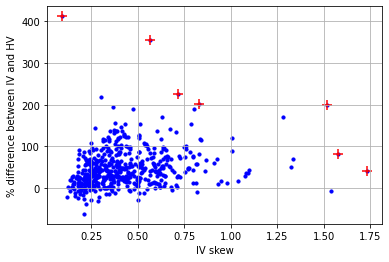

[[array(['(OCGN)', 'healthcare'], dtype='<U25') 1.7304 40.170109356014585]
 [array(['(SOS)', 'technology'], dtype='<U25') 1.574 82.87440455443245]
 [array(['(ENDP)', 'healthcare'], dtype='<U25') 1.5162 199.28938018160278]
 [array(['(IRBT)', 'consumer_cyclical'], dtype='<U25') 0.8293
  201.45401672119226]
 [array(['(OPK)', 'healthcare'], dtype='<U25') 0.7155 225.07950931394825]
 [array(['(NOK)', 'technology'], dtype='<U25') 0.5659 354.1733547351525]
 [array(['(PSTH)', 'financials'], dtype='<U25') 0.0932 412.0879120879121]]


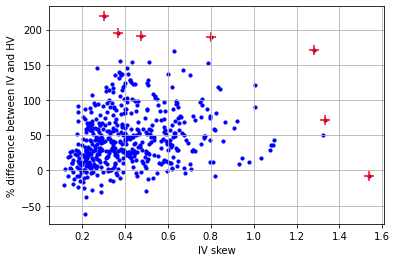

[[array(['(BBIG)', 'consumer_cyclical'], dtype='<U25') 1.5371
  -7.781377489800824]
 [array(['(SAVA)', 'healthcare'], dtype='<U25') 1.3344 71.12080020518081]
 [array(['(SNDL)', 'healthcare'], dtype='<U25') 1.281 171.34081762338488]
 [array(['(HOOD)', 'technology'], dtype='<U25') 0.8029 189.22910662824202]
 [array(['(SIRI)', 'communications'], dtype='<U25') 0.4732
  190.4849600982198]
 [array(['(BUD)', 'consumer_staple'], dtype='<U25') 0.3667
  194.77491961414793]
 [array(['(VOD)', 'communications'], dtype='<U25') 0.3014
  218.94179894179894]]


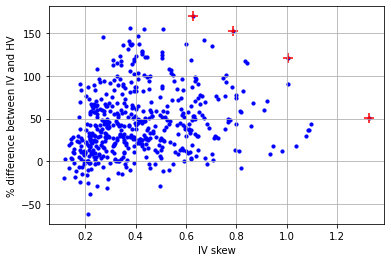

[[array(['(TMC)', 'materials'], dtype='<U25') 1.3258 50.19825535289453]
 [array(['(CYH)', 'healthcare'], dtype='<U25') 1.0062 121.04569420035148]
 [array(['(TWTR)', 'communications'], dtype='<U25') 0.7856
  152.6857510453522]
 [array(['(TEAM)', 'technology'], dtype='<U25') 0.629 169.72555746140654]]


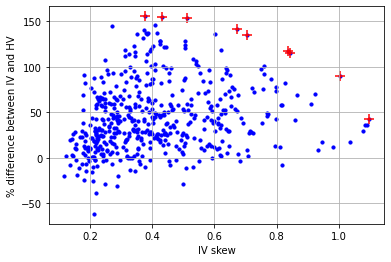

[[array(['(RIOT)', 'technology'], dtype='<U25') 1.0964 43.207941483803566]
 [array(['(FFIE)', 'consumer_cyclical'], dtype='<U25') 1.0054
  90.236518448439]
 [array(['(GP)', 'consumer_cyclical'], dtype='<U25') 0.8416
  115.51856594110114]
 [array(['(EXPR)', 'consumer_cyclical'], dtype='<U25') 0.8352
  117.89720845290898]
 [array(['(SKX)', 'consumer_cyclical'], dtype='<U25') 0.7034
  134.85809682804677]
 [array(['(GNUS)', 'technology'], dtype='<U25') 0.6719 142.1261261261261]
 [array(['(FLEX)', 'technology'], dtype='<U25') 0.5106 154.28286852589645]
 [array(['(FB)', 'communications'], dtype='<U25') 0.4319
  154.6580188679245]
 [array(['(BAX)', 'healthcare'], dtype='<U25') 0.3783 155.78093306288034]]


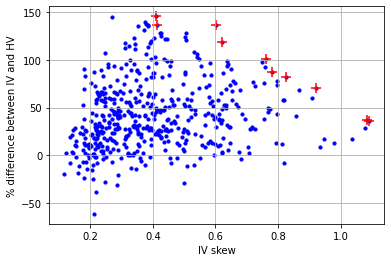

[[array(['(WISH)', 'consumer_cyclical'], dtype='<U25') 1.0898
  36.37842572894507]
 [array(['(SDC)', 'healthcare'], dtype='<U25') 1.083 36.62167276397124]
 [array(['(MVIS)', 'technology'], dtype='<U25') 0.9228 70.22689540675151]
 [array(['(SNAP)', 'communications'], dtype='<U25') 0.8268
  82.0343461030383]
 [array(['(VIR)', 'healthcare'], dtype='<U25') 0.7822 86.95028680688337]
 [array(['(NKTR)', 'healthcare'], dtype='<U25') 0.76 100.84566596194502]
 [array(['(CNC)', 'healthcare'], dtype='<U25') 0.6215 118.83802816901412]
 [array(['(MAT)', 'consumer_cyclical'], dtype='<U25') 0.6017
  136.7965367965368]
 [array(['(EBAY)', 'consumer_cyclical'], dtype='<U25') 0.4149
  137.0857142857143]
 [array(['(JNPR)', 'technology'], dtype='<U25') 0.4099 146.03841536614647]]


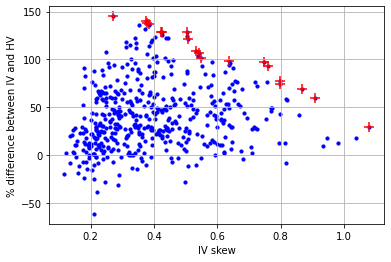

[[array(['(MARA)', 'financials'], dtype='<U25') 1.0777 29.019513947084885]
 [array(['(SKLZ)', 'communications'], dtype='<U25') 0.9093
  59.69441517386722]
 [array(['(WKHS)', 'industrials'], dtype='<U25') 0.8656 68.76584129459934]
 [array(['(ENPH)', 'energy'], dtype='<U25') 0.7975 74.01265546585206]
 [array(['(OSTK)', 'consumer_cyclical'], dtype='<U25') 0.797
  77.74308652988402]
 [array(['(AAOI)', 'technology'], dtype='<U25') 0.7591 92.76282376841036]
 [array(['(RMO)', 'consumer_cyclical'], dtype='<U25') 0.7482
  97.67503302509907]
 [array(['(ALGN)', 'healthcare'], dtype='<U25') 0.637 98.68995633187774]
 [array(['(INO)', 'healthcare'], dtype='<U25') 0.5482 101.02676934360105]
 [array(['(TDOC)', 'healthcare'], dtype='<U25') 0.5414 106.3262195121951]
 [array(['(SPOT)', 'communications'], dtype='<U25') 0.5316
  108.4705882352941]
 [array(['(HAS)', 'consumer_cyclical'], dtype='<U25') 0.5062
  121.24125874125873]
 [array(['(AMRN)', 'healthcare'], dtype='<U25') 0.5055 128.216704288939]
 [arr

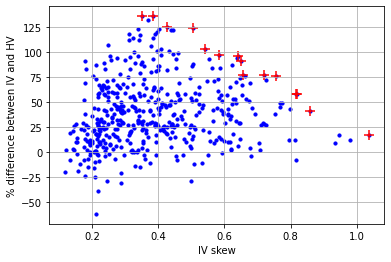

[[array(['(FCEL)', 'industrials'], dtype='<U25') 1.0362 17.50963937400771]
 [array(['(AMC)', 'consumer_cyclical'], dtype='<U25') 0.8586
  41.44975288303131]
 [array(['(RIDE)', 'consumer_cyclical'], dtype='<U25') 0.8187
  57.86733513305053]
 [array(['(MNKD)', 'healthcare'], dtype='<U25') 0.8151 58.27184466019418]
 [array(['(QS)', 'consumer_cyclical'], dtype='<U25') 0.7551
  75.80908032596042]
 [array(['(NNOX)', 'healthcare'], dtype='<U25') 0.7194 76.80019660850334]
 [array(['(CLF)', 'materials'], dtype='<U25') 0.6556 77.62124085613654]
 [array(['(SRNE)', 'healthcare'], dtype='<U25') 0.6495 90.74889867841406]
 [array(['(HOG)', 'consumer_cyclical'], dtype='<U25') 0.6409
  96.17385981022346]
 [array(['(TWLO)', 'technology'], dtype='<U25') 0.5839 96.79811257162115]
 [array(['(TEVA)', 'healthcare'], dtype='<U25') 0.5404 103.3107599699022]
 [array(['(XLNX)', 'technology'], dtype='<U25') 0.5038 124.11032028469752]
 [array(['(NOW)', 'technology'], dtype='<U25') 0.4258 125.52966101694916]
 [arra

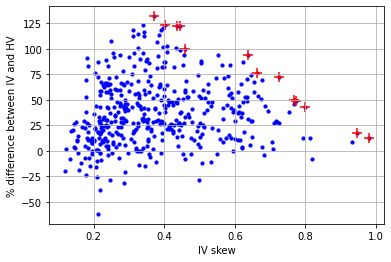

[[array(['(IRNT)', 'technology'], dtype='<U25') 0.9799 12.399632943335623]
 [array(['(GREE)', 'financials'], dtype='<U25') 0.9453 17.35567970204842]
 [array(['(APPH)', 'consumer_staple'], dtype='<U25') 0.7978
  43.077474892395976]
 [array(['(CGC)', 'healthcare'], dtype='<U25') 0.7735 48.749999999999986]
 [array(['(NEGG)', 'consumer_cyclical'], dtype='<U25') 0.7685
  49.39735614307932]
 [array(['(MSTR)', 'technology'], dtype='<U25') 0.7258 72.35810971265734]
 [array(['(CSTM)', 'materials'], dtype='<U25') 0.6626 75.8026001591934]
 [array(['(AVXL)', 'healthcare'], dtype='<U25') 0.6372 93.73669808452415]
 [array(['(SHOP)', 'technology'], dtype='<U25') 0.4592 99.30555555555556]
 [array(['(WHR)', 'consumer_cyclical'], dtype='<U25') 0.4458
  122.23330009970088]
 [array(['(TAP)', 'consumer_staple'], dtype='<U25') 0.4376
  122.35772357723576]
 [array(['(TSLA)', 'consumer_cyclical'], dtype='<U25') 0.4023
  123.50000000000001]
 [array(['(HCA)', 'healthcare'], dtype='<U25') 0.3708 131.75]]


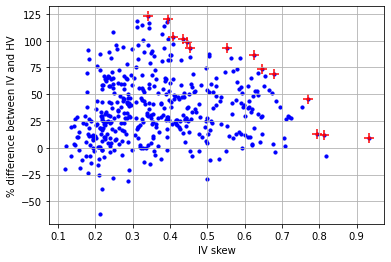

[[array(['(NVAX)', 'healthcare'], dtype='<U25') 0.9327 8.909388136384857]
 [array(['(BB)', 'technology'], dtype='<U25') 0.8124 12.194448280624231]
 [array(['(TLRY)', 'healthcare'], dtype='<U25') 0.7945 12.695035460992912]
 [array(['(LLNW)', 'technology'], dtype='<U25') 0.7688 45.68883835512604]
 [array(['(GOEV)', 'consumer_cyclical'], dtype='<U25') 0.6774
  69.0541552283504]
 [array(['(GRPN)', 'communications'], dtype='<U25') 0.647
  74.01828940290478]
 [array(['(APT)', 'healthcare'], dtype='<U25') 0.6239 86.90832834032356]
 [array(['(TECK)', 'materials'], dtype='<U25') 0.5528 93.35431969220006]
 [array(['(EGHT)', 'technology'], dtype='<U25') 0.4548 93.53191489361703]
 [array(['(VFC)', 'consumer_cyclical'], dtype='<U25') 0.4457
  98.61853832442068]
 [array(['(VALE)', 'materials'], dtype='<U25') 0.4341 101.15848007414272]
 [array(['(UAA)', 'consumer_cyclical'], dtype='<U25') 0.4078
  102.9865604778497]
 [array(['(IVR)', 'financials'], dtype='<U25') 0.3954 120.15590200445432]
 [array(['(

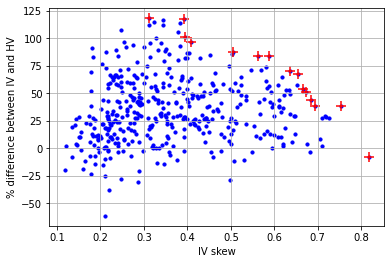

[[array(['(FUTU)', 'financials'], dtype='<U25') 0.8176
  -7.9590228526398725]
 [array(['(ATOS)', 'healthcare'], dtype='<U25') 0.7541 38.0629805931893]
 [array(['(RRC)', 'energy'], dtype='<U25') 0.6933 38.57685388766741]
 [array(['(CLOV)', 'healthcare'], dtype='<U25') 0.6844 43.81172515234294]
 [array(['(ACB)', 'healthcare'], dtype='<U25') 0.673 51.03231597845602]
 [array(['(JMIA)', 'consumer_cyclical'], dtype='<U25') 0.6653
  53.719963031423276]
 [array(['(PACB)', 'healthcare'], dtype='<U25') 0.654 67.17791411042946]
 [array(['(KODK)', 'industrials'], dtype='<U25') 0.6352 49.17801784875528]
 [array(['(WW)', 'consumer_cyclical'], dtype='<U25') 0.5868
  83.94984326018809]
 [array(['(NOV)', 'energy'], dtype='<U25') 0.5626 84.15711947626842]
 [array(['(LVS)', 'consumer_cyclical'], dtype='<U25') 0.5042
  87.9239657100261]
 [array(['(CVNA)', 'consumer_cyclical'], dtype='<U25') 0.4092
  96.73076923076924]
 [array(['(KLAC)', 'technology'], dtype='<U25') 0.3955 101.58002038735982]
 [array(['(IN

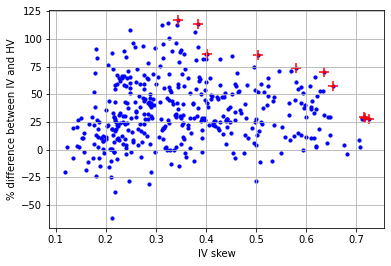

[[array(['(NKLA)', 'industrials'], dtype='<U25') 0.7254
  27.554070687532985]
 [array(['(FSLY)', 'technology'], dtype='<U25') 0.7182 28.70967741935482]
 [array(['(HUYA)', 'technology'], dtype='<U25') 0.7157 29.30442637759711]
 [array(['(AMRS)', 'materials'], dtype='<U25') 0.653 57.539203860072384]
 [array(['(CLVS)', 'healthcare'], dtype='<U25') 0.6352 70.0669344042838]
 [array(['(INFN)', 'technology'], dtype='<U25') 0.5802 73.60861759425495]
 [array(['(AMD)', 'technology'], dtype='<U25') 0.5034 85.75645756457561]
 [array(['(GM)', 'consumer_cyclical'], dtype='<U25') 0.4029
  86.70064874884152]
 [array(['(GE)', 'industrials'], dtype='<U25') 0.3839 113.75278396436525]
 [array(['(BHC)', 'healthcare'], dtype='<U25') 0.344 116.76118462507874]]


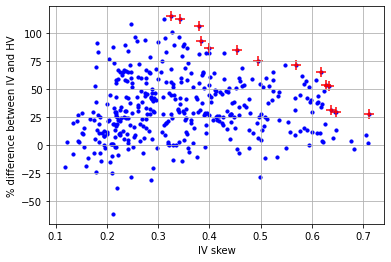

[[array(['(RIG)', 'energy'], dtype='<U25') 0.7108 27.38351254480285]
 [array(['(VIPS)', 'consumer_cyclical'], dtype='<U25') 0.6473
  29.64149809733626]
 [array(['(LCID)', 'consumer_cyclical'], dtype='<U25') 0.6361
  31.42561983471075]
 [array(['(X)', 'materials'], dtype='<U25') 0.6332 52.7992277992278]
 [array(['(FOSL)', 'consumer_cyclical'], dtype='<U25') 0.6275
  52.97415894685518]
 [array(['(BLNK)', 'industrials'], dtype='<U25') 0.6182 65.16163505209724]
 [array(['(CODX)', 'healthcare'], dtype='<U25') 0.5691 71.31246237206504]
 [array(['(THC)', 'healthcare'], dtype='<U25') 0.4952 74.67372134038801]
 [array(['(GPRO)', 'technology'], dtype='<U25') 0.4529 84.4806517311609]
 [array(['(PAA)', 'energy'], dtype='<U25') 0.3994 86.63551401869158]
 [array(['(PSXP)', 'energy'], dtype='<U25') 0.3837 92.81407035175879]
 [array(['(EW)', 'healthcare'], dtype='<U25') 0.3788 106.09357997823723]
 [array(['(GLW)', 'technology'], dtype='<U25') 0.343 112.12121212121214]
 [array(['(KHC)', 'consumer_stapl

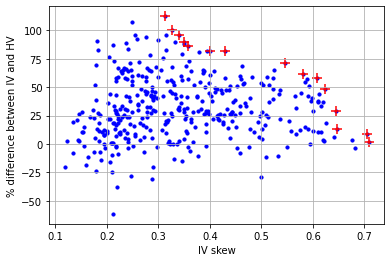

[[array(['(UPST)', 'financials'], dtype='<U25') 0.7086 2.0302375809935205]
 [array(['(AFRM)', 'technology'], dtype='<U25') 0.7051 8.794939052615328]
 [array(['(SOL)', 'technology'], dtype='<U25') 0.6476 13.256383350821963]
 [array(['(ARVL)', 'industrials'], dtype='<U25') 0.6446
  29.204249348566837]
 [array(['(GME)', 'consumer_cyclical'], dtype='<U25') 0.6224
  48.1552011425851]
 [array(['(DIDI)', 'technology'], dtype='<U25') 0.6083 57.67236910316226]
 [array(['(FSR)', 'consumer_cyclical'], dtype='<U25') 0.5798
  61.459203564466726]
 [array(['(CHPT)', 'industrials'], dtype='<U25') 0.5464 71.12433448167869]
 [array(['(AAL)', 'consumer_cyclical'], dtype='<U25') 0.4283
  81.86836518046711]
 [array(['(RCL)', 'industrials'], dtype='<U25') 0.3999 82.18678815489749]
 [array(['(MT)', 'materials'], dtype='<U25') 0.357 86.0343929129755]
 [array(['(BA)', 'industrials'], dtype='<U25') 0.3505 90.07592190889369]
 [array(['(NSC)', 'industrials'], dtype='<U25') 0.34 96.07843137254903]
 [array(['(LITE)

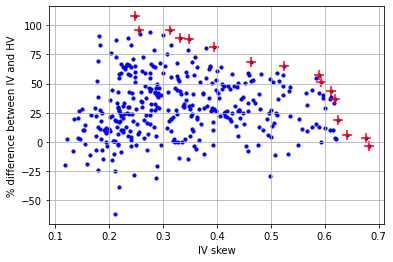

[[array(['(PINS)', 'communications'], dtype='<U25') 0.6818
  -3.7277605196272363]
 [array(['(CCJ)', 'materials'], dtype='<U25') 0.6759 3.7611298741172803]
 [array(['(IQ)', 'communications'], dtype='<U25') 0.6417
  5.838693715982203]
 [array(['(SWN)', 'energy'], dtype='<U25') 0.6253 18.47290640394087]
 [array(['(DDD)', 'technology'], dtype='<U25') 0.6196 36.68652106772558]
 [array(['(SPCE)', 'consumer_cyclical'], dtype='<U25') 0.6118
  43.51395730706075]
 [array(['(LMND)', 'financials'], dtype='<U25') 0.5931 51.378254211332305]
 [array(['(APPS)', 'technology'], dtype='<U25') 0.5889 56.95628997867804]
 [array(['(ADS)', 'financials'], dtype='<U25') 0.5245 65.04090623033352]
 [array(['(STX)', 'technology'], dtype='<U25') 0.4626 68.83211678832116]
 [array(['(CC)', 'materials'], dtype='<U25') 0.3939 81.68819188191881]
 [array(['(CHTR)', 'communications'], dtype='<U25') 0.3487
  88.18132757690233]
 [array(['(CAT)', 'industrials'], dtype='<U25') 0.3317 89.4346087949743]
 [array(['(AMZN)', 'con

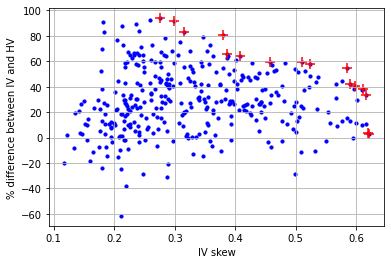

[[array(['(SPWR)', 'energy'], dtype='<U25') 0.6206 2.409240924092419]
 [array(['(GRWG)', 'consumer_cyclical'], dtype='<U25') 0.6195
  3.5606820461384316]
 [array(['(BILI)', 'communications'], dtype='<U25') 0.6165
  33.38381652964086]
 [array(['(CRSP)', 'healthcare'], dtype='<U25') 0.6107 38.104929895974685]
 [array(['(EDIT)', 'healthcare'], dtype='<U25') 0.5973 40.34304511278197]
 [array(['(YPF)', 'energy'], dtype='<U25') 0.5902 42.07992296581607]
 [array(['(STEM)', 'technology'], dtype='<U25') 0.5842 54.63208046585495]
 [array(['(WDC)', 'technology'], dtype='<U25') 0.5232 57.78045838359469]
 [array(['(VXRT)', 'healthcare'], dtype='<U25') 0.5106 59.313572542901724]
 [array(['(LL)', 'consumer_cyclical'], dtype='<U25') 0.4575
  59.46322760543745]
 [array(['(PLTR)', 'technology'], dtype='<U25') 0.4082 64.19951729686244]
 [array(['(MTCH)', 'communications'], dtype='<U25') 0.3869
  65.34188034188034]
 [array(['(LRCX)', 'technology'], dtype='<U25') 0.3795 80.6282722513089]
 [array(['(VRTX)',

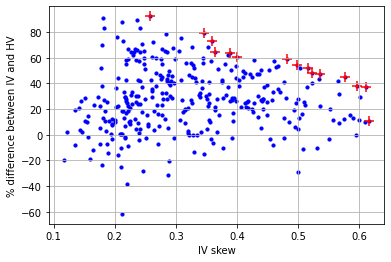

[[array(['(OPEN)', 'real_estate'], dtype='<U25') 0.6155
  10.363994979379608]
 [array(['(RVLV)', 'consumer_cyclical'], dtype='<U25') 0.6102
  37.031214911295756]
 [array(['(CRON)', 'consumer_staple'], dtype='<U25') 0.5958
  37.85284590467377]
 [array(['(SOLO)', 'consumer_cyclical'], dtype='<U25') 0.5771
  44.67285033843068]
 [array(['(OLN)', 'materials'], dtype='<U25') 0.536 47.49587231700606]
 [array(['(PTON)', 'consumer_cyclical'], dtype='<U25') 0.5232
  48.13137032842582]
 [array(['(CYRX)', 'industrials'], dtype='<U25') 0.5154
  52.125147579693035]
 [array(['(PBR)', 'energy'], dtype='<U25') 0.4985 53.95305744286598]
 [array(['(YY)', 'communications'], dtype='<U25') 0.482 58.60480421191181]
 [array(['(WB)', 'communications'], dtype='<U25') 0.4004
  60.80321285140562]
 [array(['(SQ)', 'financials'], dtype='<U25') 0.388 63.92057456696241]
 [array(['(EXPE)', 'communications'], dtype='<U25') 0.3633
  64.46355817111815]
 [array(['(TSCO)', 'consumer_cyclical'], dtype='<U25') 0.3588
  72.91

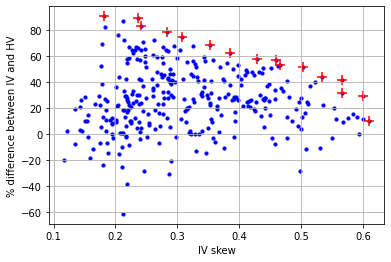

[[array(['(SOFI)', 'financials'], dtype='<U25') 0.6095 10.216998191681734]
 [array(['(TME)', 'communications'], dtype='<U25') 0.6004
  29.396551724137932]
 [array(['(BNTX)', 'healthcare'], dtype='<U25') 0.5666 31.33982382939267]
 [array(['(HYLN)', 'industrials'], dtype='<U25') 0.5658 41.9112114371708]
 [array(['(GT)', 'consumer_cyclical'], dtype='<U25') 0.5338
  43.765149474818216]
 [array(['(PENN)', 'consumer_cyclical'], dtype='<U25') 0.5035
  51.70231997589635]
 [array(['(TTCF)', 'consumer_staple'], dtype='<U25') 0.4666
  53.234811165845656]
 [array(['(SABR)', 'technology'], dtype='<U25') 0.46 57.211209842788776]
 [array(['(BABA)', 'consumer_cyclical'], dtype='<U25') 0.4282
  58.29944547134935]
 [array(['(BX)', 'financials'], dtype='<U25') 0.3857 62.26335717290702]
 [array(['(DISH)', 'communications'], dtype='<U25') 0.3531
  68.38340486409157]
 [array(['(ET)', 'energy'], dtype='<U25') 0.308 75.19908987485778]
 [array(['(ILMN)', 'healthcare'], dtype='<U25') 0.284 78.61635220125784]
 [

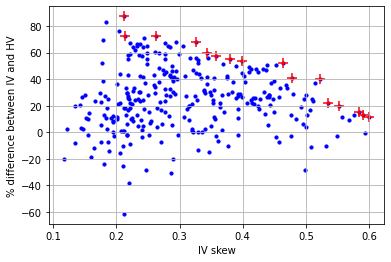

[[array(['(FUBO)', 'communications'], dtype='<U25') 0.5996
  11.574246371417944]
 [array(['(BBBY)', 'consumer_cyclical'], dtype='<U25') 0.5898
  13.09683604985619]
 [array(['(HIMX)', 'technology'], dtype='<U25') 0.584 15.210100611560454]
 [array(['(HL)', 'materials'], dtype='<U25') 0.5526 20.07822685788787]
 [array(['(SFIX)', 'consumer_cyclical'], dtype='<U25') 0.5357
  22.30593607305935]
 [array(['(QDEL)', 'healthcare'], dtype='<U25') 0.5221 39.93567408201555]
 [array(['(FCX)', 'materials'], dtype='<U25') 0.4776 40.843409023886764]
 [array(['(Z)', 'communications'], dtype='<U25') 0.4633
  52.451464297466266]
 [array(['(MOS)', 'materials'], dtype='<U25') 0.3986 53.48479014247209]
 [array(['(UBER)', 'communications'], dtype='<U25') 0.38
  54.91235222176927]
 [array(['(PHM)', 'consumer_cyclical'], dtype='<U25') 0.3571
  57.45149911816577]
 [array(['(PSX)', 'energy'], dtype='<U25') 0.3436 59.66542750929369]
 [array(['(PPG)', 'materials'], dtype='<U25') 0.3255 67.95665634674923]
 [array(['

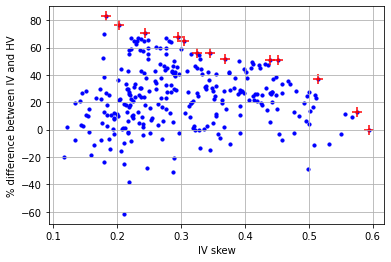

[[array(['(PLUG)', 'energy'], dtype='<U25') 0.5938 -0.2519737947253581]
 [array(['(COIN)', 'financials'], dtype='<U25') 0.5756 12.641878669275927]
 [array(['(LAZR)', 'technology'], dtype='<U25') 0.5139 37.113127001067234]
 [array(['(F)', 'consumer_cyclical'], dtype='<U25') 0.452
  50.61646117960681]
 [array(['(EXAS)', 'healthcare'], dtype='<U25') 0.4385 50.79092159559835]
 [array(['(JD)', 'consumer_cyclical'], dtype='<U25') 0.3684
  51.48026315789473]
 [array(['(VLO)', 'energy'], dtype='<U25') 0.345 56.108597285067866]
 [array(['(TXN)', 'technology'], dtype='<U25') 0.3252 56.195965417867434]
 [array(['(CSX)', 'industrials'], dtype='<U25') 0.3047 65.14905149051492]
 [array(['(VIAC)', 'communications'], dtype='<U25') 0.295
  67.89982925441093]
 [array(['(EPD)', 'energy'], dtype='<U25') 0.2444 70.90909090909093]
 [array(['(CL)', 'consumer_staple'], dtype='<U25') 0.2037
  76.36363636363635]
 [array(['(KO)', 'consumer_staple'], dtype='<U25') 0.1827
  82.88288288288288]]


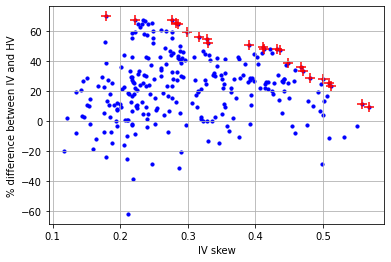

[[array(['(SSYS)', 'technology'], dtype='<U25') 0.5675 9.050730207532673]
 [array(['(MRNA)', 'healthcare'], dtype='<U25') 0.557 11.244258038745759]
 [array(['(APA)', 'energy'], dtype='<U25') 0.5118 23.29559142375331]
 [array(['(AG)', 'materials'], dtype='<U25') 0.5092 25.110565110565116]
 [array(['(RAD)', 'consumer_staple'], dtype='<U25') 0.5002
  4.230047926651383]
 [array(['(PLAY)', 'consumer_cyclical'], dtype='<U25') 0.48
  28.4796573875803]
 [array(['(OXY)', 'energy'], dtype='<U25') 0.4708 33.44671201814059]
 [array(['(ETSY)', 'consumer_cyclical'], dtype='<U25') 0.4678
  35.869880917804245]
 [array(['(LI)', 'consumer_cyclical'], dtype='<U25') 0.4488
  38.518518518518505]
 [array(['(AUY)', 'materials'], dtype='<U25') 0.4366 47.052879757494104]
 [array(['(MRO)', 'energy'], dtype='<U25') 0.432 47.64183185235815]
 [array(['(URI)', 'industrials'], dtype='<U25') 0.413 47.9756359727696]
 [array(['(RBLX)', 'communications'], dtype='<U25') 0.4104
  49.34497816593887]
 [array(['(MELI)', 'con

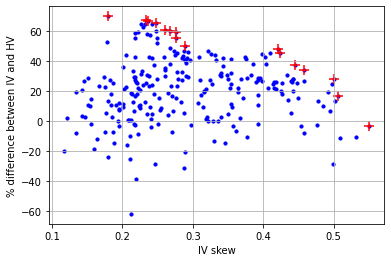

[[array(['(NET)', 'technology'], dtype='<U25') 0.5498 -3.0164050097018884]
 [array(['(XPEV)', 'consumer_cyclical'], dtype='<U25') 0.506
  16.482504604051567]
 [array(['(W)', 'consumer_cyclical'], dtype='<U25') 0.5002
  27.699770232320652]
 [array(['(CPRI)', 'consumer_cyclical'], dtype='<U25') 0.4585
  33.634508889536576]
 [array(['(DKNG)', 'consumer_cyclical'], dtype='<U25') 0.4444
  37.075879086983356]
 [array(['(NCLH)', 'consumer_cyclical'], dtype='<U25') 0.4241
  45.23972602739726]
 [array(['(NTES)', 'technology'], dtype='<U25') 0.4215 47.53237661883093]
 [array(['(HPE)', 'technology'], dtype='<U25') 0.2883 49.99999999999999]
 [array(['(REGN)', 'healthcare'], dtype='<U25') 0.2767 55.100896860986545]
 [array(['(TTWO)', 'technology'], dtype='<U25') 0.2761 59.31909982688979]
 [array(['(NTR)', 'materials'], dtype='<U25') 0.2675 59.51103160405488]
 [array(['(BKNG)', 'communications'], dtype='<U25') 0.2606
  60.665844636251535]
 [array(['(UNP)', 'industrials'], dtype='<U25') 0.2476 65.287

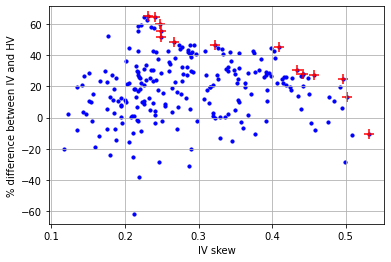

[[array(['(STNE)', 'financials'], dtype='<U25') 0.5314 -10.49351524338892]
 [array(['(PDD)', 'consumer_cyclical'], dtype='<U25') 0.5015
  13.307727067329406]
 [array(['(DDOG)', 'technology'], dtype='<U25') 0.497 24.843004270283846]
 [array(['(CLR)', 'energy'], dtype='<U25') 0.4574 26.879334257975028]
 [array(['(TTD)', 'technology'], dtype='<U25') 0.4418 27.761711972238295]
 [array(['(GNW)', 'financials'], dtype='<U25') 0.4337 30.396873120865898]
 [array(['(NUE)', 'materials'], dtype='<U25') 0.41 45.28703047484053]
 [array(['(DOW)', 'materials'], dtype='<U25') 0.322 46.63023679417123]
 [array(['(HLF)', 'consumer_staple'], dtype='<U25') 0.267
  48.1687014428413]
 [array(['(RTX)', 'industrials'], dtype='<U25') 0.2488 51.52253349573689]
 [array(['(CNP)', 'utilities'], dtype='<U25') 0.2484 55.44430538172717]
 [array(['(XOM)', 'energy'], dtype='<U25') 0.2478 59.87096774193547]
 [array(['(NOC)', 'industrials'], dtype='<U25') 0.2414 64.55351056578051]
 [array(['(CVX)', 'energy'], dtype='<U25')

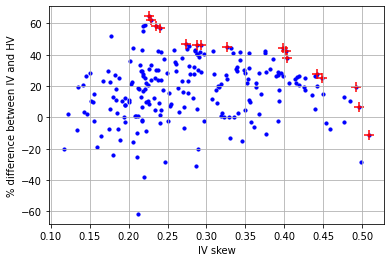

[[array(['(AA)', 'materials'], dtype='<U25') 0.5084 -11.459421804249404]
 [array(['(SRPT)', 'healthcare'], dtype='<U25') 0.4954 6.354658651781884]
 [array(['(COTY)', 'consumer_staple'], dtype='<U25') 0.4925
  19.307170542635657]
 [array(['(NIO)', 'consumer_cyclical'], dtype='<U25') 0.4482
  25.160569673275628]
 [array(['(TTD)', 'communications'], dtype='<U25') 0.4418
  27.761711972238295]
 [array(['(URBN)', 'consumer_cyclical'], dtype='<U25') 0.4036
  38.03009575923394]
 [array(['(CCL)', 'consumer_cyclical'], dtype='<U25') 0.4024
  42.34170498761937]
 [array(['(HES)', 'energy'], dtype='<U25') 0.3984 26.43605204696921]
 [array(['(PXD)', 'energy'], dtype='<U25') 0.3258 44.73567303420701]
 [array(['(BSX)', 'healthcare'], dtype='<U25') 0.2936 46.06965174129354]
 [array(['(ASML)', 'technology'], dtype='<U25') 0.2878 46.314184036603955]
 [array(['(BMY)', 'healthcare'], dtype='<U25') 0.2736 46.62379421221867]
 [array(['(ABT)', 'healthcare'], dtype='<U25') 0.2398 57.3490813648294]
 [array(['(A

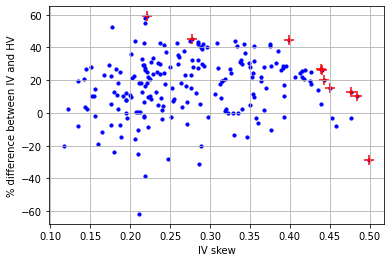

[[array(['(M)', 'consumer_cyclical'], dtype='<U25') 0.499
  -28.724467933152404]
 [array(['(ACAD)', 'healthcare'], dtype='<U25') 0.4847 10.309512972234867]
 [array(['(TTM)', 'consumer_cyclical'], dtype='<U25') 0.4772
  13.027001421127427]
 [array(['(JWN)', 'consumer_cyclical'], dtype='<U25') 0.4498
  15.067792274238922]
 [array(['(ANF)', 'consumer_cyclical'], dtype='<U25') 0.4424
  20.184732409671295]
 [array(['(DVN)', 'energy'], dtype='<U25') 0.4408 26.23138602520046]
 [array(['(ROKU)', 'communications'], dtype='<U25') 0.4392
  26.716676283900735]
 [array(['(WYNN)', 'consumer_cyclical'], dtype='<U25') 0.3984
  44.55732946298983]
 [array(['(KMI)', 'energy'], dtype='<U25') 0.2778 45.29288702928869]
 [array(['(MCD)', 'consumer_cyclical'], dtype='<U25') 0.2214
  59.051724137931046]]


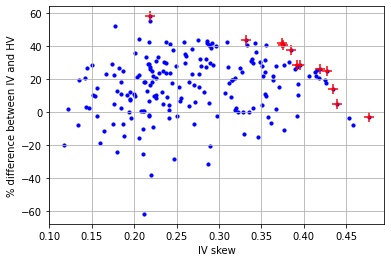

[[array(['(FLR)', 'industrials'], dtype='<U25') 0.4766 -2.814029363784661]
 [array(['(FSLR)', 'energy'], dtype='<U25') 0.4396 5.268199233716466]
 [array(['(CSIQ)', 'energy'], dtype='<U25') 0.4349 14.027267960146824]
 [array(['(SHAK)', 'consumer_cyclical'], dtype='<U25') 0.4271
  25.029274004683828]
 [array(['(CZR)', 'consumer_cyclical'], dtype='<U25') 0.4187
  26.1524555589033]
 [array(['(WOOF)', 'consumer_cyclical'], dtype='<U25') 0.3953
  28.59466493168509]
 [array(['(RNG)', 'technology'], dtype='<U25') 0.3918 27.37321196358908]
 [array(['(BIDU)', 'communications'], dtype='<U25') 0.3849
  37.5625446747677]
 [array(['(UAL)', 'consumer_cyclical'], dtype='<U25') 0.375
  41.03046257991725]
 [array(['(SLB)', 'energy'], dtype='<U25') 0.3746 42.271173566274214]
 [array(['(LUV)', 'consumer_cyclical'], dtype='<U25') 0.3314
  44.02433724467622]
 [array(['(ADSK)', 'technology'], dtype='<U25') 0.2182 58.23060188542423]]


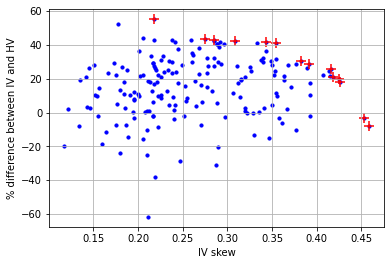

[[array(['(SIG)', 'consumer_cyclical'], dtype='<U25') 0.4582
  -7.676808382027005]
 [array(['(AMBA)', 'technology'], dtype='<U25') 0.4533 -3.326935380678184]
 [array(['(CWH)', 'consumer_cyclical'], dtype='<U25') 0.4261
  17.804810616533025]
 [array(['(MOMO)', 'communications'], dtype='<U25') 0.4248
  19.661971830985927]
 [array(['(LYFT)', 'communications'], dtype='<U25') 0.4182
  20.97194098929708]
 [array(['(AEO)', 'consumer_cyclical'], dtype='<U25') 0.4157
  25.741076830006055]
 [array(['(BYND)', 'consumer_staple'], dtype='<U25') 0.3918
  28.796844181459548]
 [array(['(SYF)', 'financials'], dtype='<U25') 0.3822 30.622009569377973]
 [array(['(SU)', 'energy'], dtype='<U25') 0.3548 40.96146205800558]
 [array(['(HBI)', 'consumer_cyclical'], dtype='<U25') 0.3428
  41.887417218543035]
 [array(['(DBX)', 'technology'], dtype='<U25') 0.309 42.52767527675277]
 [array(['(AMAT)', 'technology'], dtype='<U25') 0.2855 43.03607214428857]
 [array(['(CMCSA)', 'communications'], dtype='<U25') 0.2753
  

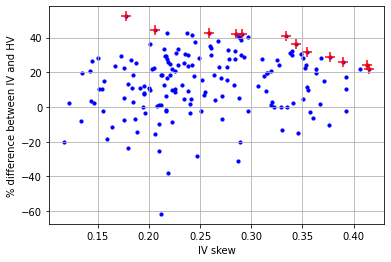

[[array(['(TNDM)', 'healthcare'], dtype='<U25') 0.4148 21.856639247943605]
 [array(['(TRIP)', 'communications'], dtype='<U25') 0.4134
  24.443106562311858]
 [array(['(HPQ)', 'technology'], dtype='<U25') 0.3892 26.158833063209073]
 [array(['(KSS)', 'consumer_cyclical'], dtype='<U25') 0.3769
  28.89876880984953]
 [array(['(DFS)', 'financials'], dtype='<U25') 0.3546 31.57699443413729]
 [array(['(RL)', 'consumer_cyclical'], dtype='<U25') 0.3434
  36.37807783955518]
 [array(['(NTNX)', 'technology'], dtype='<U25') 0.3335 40.83614864864865]
 [array(['(MAR)', 'consumer_cyclical'], dtype='<U25') 0.2912
  41.910331384015606]
 [array(['(OKE)', 'energy'], dtype='<U25') 0.2852 42.10264075734929]
 [array(['(ADM)', 'consumer_staple'], dtype='<U25') 0.2589
  42.80198565912853]
 [array(['(WMB)', 'energy'], dtype='<U25') 0.2056 44.17952314165498]
 [array(['(AZN)', 'healthcare'], dtype='<U25') 0.1774 52.27467811158798]]


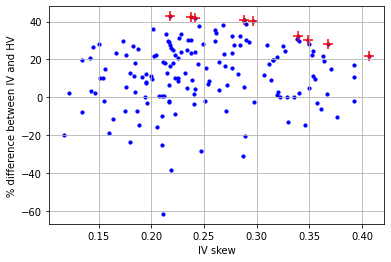

[[array(['(MDB)', 'technology'], dtype='<U25') 0.4065 21.925614877024596]
 [array(['(KGC)', 'materials'], dtype='<U25') 0.3677 28.163123039386562]
 [array(['(GOOS)', 'consumer_cyclical'], dtype='<U25') 0.3488
  30.441286462228856]
 [array(['(ABNB)', 'communications'], dtype='<U25') 0.3394
  32.16510903426792]
 [array(['(COP)', 'energy'], dtype='<U25') 0.2964 40.40738986262434]
 [array(['(FISV)', 'technology'], dtype='<U25') 0.2884 40.5458089668616]
 [array(['(T)', 'communications'], dtype='<U25') 0.2418 41.65202108963093]
 [array(['(PFE)', 'healthcare'], dtype='<U25') 0.2376 42.617046818727495]
 [array(['(DIS)', 'communications'], dtype='<U25') 0.2176
  42.782152230971114]]


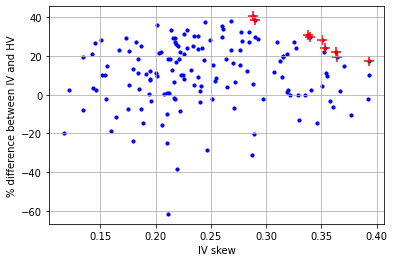

[[array(['(SONO)', 'technology'], dtype='<U25') 0.3928 17.28874290833085]
 [array(['(SEAS)', 'consumer_cyclical'], dtype='<U25') 0.3637
  19.285011479173505]
 [array(['(PCG)', 'utilities'], dtype='<U25') 0.3635 21.816353887399462]
 [array(['(HFC)', 'energy'], dtype='<U25') 0.3536 24.33192686357245]
 [array(['(SNOW)', 'communications'], dtype='<U25') 0.3501
  28.100987925356762]
 [array(['(COF)', 'financials'], dtype='<U25') 0.3398 29.694656488549608]
 [array(['(ZNGA)', 'technology'], dtype='<U25') 0.3379 30.867544539116963]
 [array(['(ANET)', 'technology'], dtype='<U25') 0.2902 38.851674641148335]
 [array(['(FISV)', 'financials'], dtype='<U25') 0.2884 40.5458089668616]]


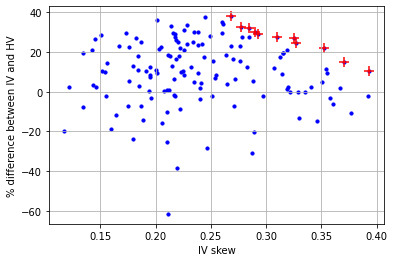

[[array(['(CHWY)', 'consumer_cyclical'], dtype='<U25') 0.3928
  10.430137756536396]
 [array(['(DASH)', 'communications'], dtype='<U25') 0.3706
  15.057435579012726]
 [array(['(BBWI)', 'consumer_cyclical'], dtype='<U25') 0.3522
  22.2492190211732]
 [array(['(ZM)', 'technology'], dtype='<U25') 0.3268 24.353120243531205]
 [array(['(LUMN)', 'communications'], dtype='<U25') 0.3249
  27.06296441141965]
 [array(['(SPLK)', 'technology'], dtype='<U25') 0.3102 27.39219712525667]
 [array(['(NXPI)', 'technology'], dtype='<U25') 0.2929 28.917253521126753]
 [array(['(KEY)', 'financials'], dtype='<U25') 0.2896 30.040413111809617]
 [array(['(NEM)', 'materials'], dtype='<U25') 0.2845 32.32558139534883]
 [array(['(NVDA)', 'technology'], dtype='<U25') 0.277 32.53588516746413]
 [array(['(MPC)', 'energy'], dtype='<U25') 0.268 38.07315816589389]]


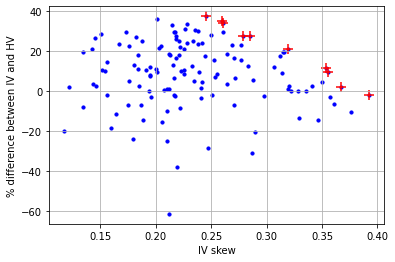

[[array(['(GPS)', 'consumer_cyclical'], dtype='<U25') 0.3922
  -2.2432701894317066]
 [array(['(MGM)', 'consumer_cyclical'], dtype='<U25') 0.3672
  1.8867924528301967]
 [array(['(CF)', 'materials'], dtype='<U25') 0.3554 9.657513113236654]
 [array(['(RKT)', 'financials'], dtype='<U25') 0.354 11.320754716981124]
 [array(['(OKTA)', 'technology'], dtype='<U25') 0.3192 1.172741679873211]
 [array(['(AXP)', 'financials'], dtype='<U25') 0.2846 27.45185848634126]
 [array(['(MA)', 'financials'], dtype='<U25') 0.2785 27.810922441486923]
 [array(['(SWKS)', 'technology'], dtype='<U25') 0.2611 34.034907597535934]
 [array(['(KKR)', 'financials'], dtype='<U25') 0.2601 35.257410296411855]
 [array(['(V)', 'financials'], dtype='<U25') 0.2451 37.464946719012914]]


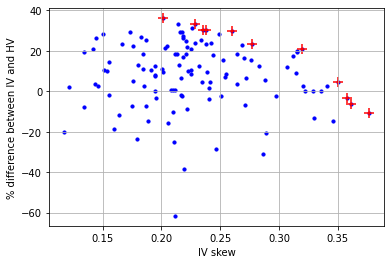

[[array(['(SE)', 'technology'], dtype='<U25') 0.3763 -10.553838840028522]
 [array(['(HAL)', 'energy'], dtype='<U25') 0.3608 -6.407263294422827]
 [array(['(COUP)', 'technology'], dtype='<U25') 0.3576 -3.089430894308949]
 [array(['(EOG)', 'energy'], dtype='<U25') 0.3501 4.694976076555038]
 [array(['(YETI)', 'consumer_cyclical'], dtype='<U25') 0.3192
  21.000758150113725]
 [array(['(VMW)', 'technology'], dtype='<U25') 0.2768 23.296213808463246]
 [array(['(VTRS)', 'healthcare'], dtype='<U25') 0.2604 29.74588938714501]
 [array(['(QCOM)', 'technology'], dtype='<U25') 0.238 23.57217030114226]
 [array(['(CLX)', 'consumer_staple'], dtype='<U25') 0.2351
  30.32150776053215]
 [array(['(AMT)', 'financials'], dtype='<U25') 0.2284 33.41121495327103]
 [array(['(LMT)', 'industrials'], dtype='<U25') 0.2013 36.105476673427994]]


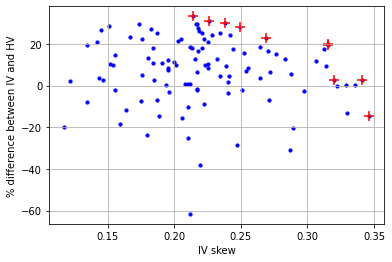

[[array(['(CRWD)', 'technology'], dtype='<U25') 0.346 -14.799310514651573]
 [array(['(CYBR)', 'technology'], dtype='<U25') 0.3406 2.497743003310271]
 [array(['(PZZA)', 'consumer_cyclical'], dtype='<U25') 0.32
  2.596986213529976]
 [array(['(ZS)', 'technology'], dtype='<U25') 0.3156 19.454958364875097]
 [array(['(DAL)', 'consumer_cyclical'], dtype='<U25') 0.3152
  19.756838905775073]
 [array(['(GOLD)', 'materials'], dtype='<U25') 0.2686 22.985347985347982]
 [array(['(CME)', 'financials'], dtype='<U25') 0.2494 28.16032887975335]
 [array(['(KMX)', 'consumer_cyclical'], dtype='<U25') 0.238
  30.125751776927274]
 [array(['(CIEN)', 'technology'], dtype='<U25') 0.2261 31.14849187935035]
 [array(['(AFL)', 'financials'], dtype='<U25') 0.2144 33.25046612802985]]


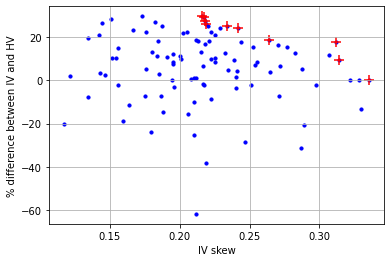

[[array(['(PYPL)', 'financials'], dtype='<U25') 0.3353
  0.08955223880596028]
 [array(['(DOCU)', 'technology'], dtype='<U25') 0.3141 9.176225234619388]
 [array(['(WPM)', 'materials'], dtype='<U25') 0.3121 17.59608138658627]
 [array(['(EA)', 'technology'], dtype='<U25') 0.264 18.598382749326156]
 [array(['(DHI)', 'consumer_cyclical'], dtype='<U25') 0.242
  24.102564102564095]
 [array(['(PANW)', 'technology'], dtype='<U25') 0.234 25.20064205457464]
 [array(['(A)', 'communications'], dtype='<U25') 0.2186 26.13964223889208]
 [array(['(MRK)', 'healthcare'], dtype='<U25') 0.218 27.485380116959053]
 [array(['(MET)', 'financials'], dtype='<U25') 0.2172 29.362715902322815]
 [array(['(CAG)', 'consumer_staple'], dtype='<U25') 0.2162
  29.53864589574596]]


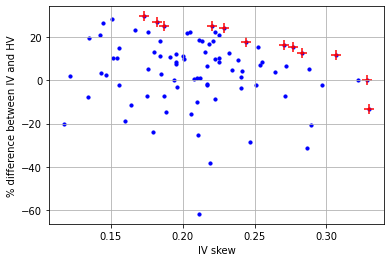

[[array(['(APO)', 'financials'], dtype='<U25') 0.3296 -13.3087848500789]
 [array(['(DKS)', 'consumer_cyclical'], dtype='<U25') 0.3286
  0.060901339829469534]
 [array(['(FIVE)', 'consumer_staple'], dtype='<U25') 0.3067
  11.811884797666783]
 [array(['(TOL)', 'consumer_cyclical'], dtype='<U25') 0.2828
  12.490055688146374]
 [array(['(MRVL)', 'technology'], dtype='<U25') 0.2766 15.298040850354319]
 [array(['(MCHP)', 'technology'], dtype='<U25') 0.2702 16.41533821628608]
 [array(['(AIG)', 'financials'], dtype='<U25') 0.2442 17.686746987951814]
 [array(['(SWK)', 'consumer_cyclical'], dtype='<U25') 0.2286
  24.0368963646229]
 [array(['(MO)', 'consumer_staple'], dtype='<U25') 0.2206
  24.98583569405099]
 [array(['(MNST)', 'consumer_staple'], dtype='<U25') 0.1872
  25.217391304347835]
 [array(['(BDX)', 'healthcare'], dtype='<U25') 0.1824 27.019498607242337]
 [array(['(HRL)', 'consumer_staple'], dtype='<U25') 0.1733
  29.521674140508225]]


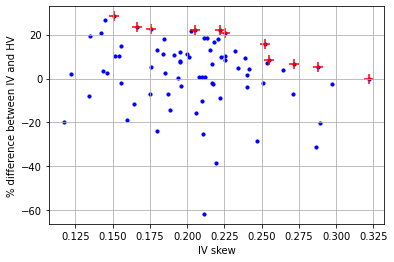

[[array(['(RH)', 'consumer_cyclical'], dtype='<U25') 0.322
  -0.03104625892579602]
 [array(['(BIIB)', 'healthcare'], dtype='<U25') 0.2878 5.38264372024899]
 [array(['(FOXA)', 'communications'], dtype='<U25') 0.2716
  6.468051744413961]
 [array(['(SCHW)', 'financials'], dtype='<U25') 0.255 8.51063829787235]
 [array(['(NFLX)', 'communications'], dtype='<U25') 0.2522
  15.529088410444336]
 [array(['(NTAP)', 'technology'], dtype='<U25') 0.2253 20.93397745571659]
 [array(['(BK)', 'financials'], dtype='<U25') 0.2222 -8.634868421052627]
 [array(['(CAH)', 'healthcare'], dtype='<U25') 0.205 22.31503579952267]
 [array(['(TSN)', 'consumer_staple'], dtype='<U25') 0.1756
  22.45467224546723]
 [array(['(KSU)', 'industrials'], dtype='<U25') 0.1666 23.316062176165804]
 [array(['(SO)', 'utilities'], dtype='<U25') 0.1507 28.364565587734237]]


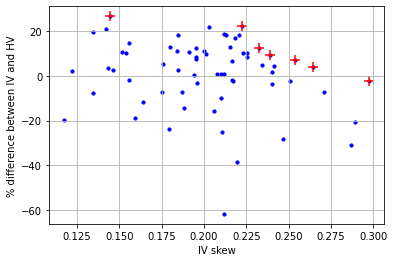

[[array(['(IP)', 'materials'], dtype='<U25') 0.2973 -2.396585686145756]
 [array(['(MU)', 'technology'], dtype='<U25') 0.2645 3.725490196078435]
 [array(['(LEN)', 'consumer_cyclical'], dtype='<U25') 0.2537
  7.0464135021097025]
 [array(['(CI)', 'healthcare'], dtype='<U25') 0.2387 9.34493815849748]
 [array(['(DE)', 'industrials'], dtype='<U25') 0.2324 12.596899224806199]
 [array(['(MCK)', 'healthcare'], dtype='<U25') 0.2222 22.087912087912095]
 [array(['(WMT)', 'consumer_staple'], dtype='<U25') 0.1448
  26.573426573426584]]


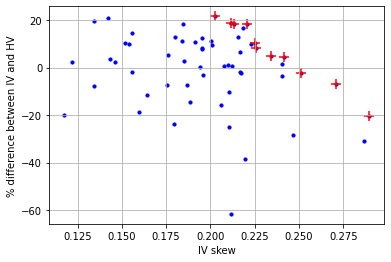

[[array(['(BURL)', 'consumer_cyclical'], dtype='<U25') 0.2893
  -20.43454345434543]
 [array(['(CTXS)', 'technology'], dtype='<U25') 0.271 -7.032590051457964]
 [array(['(ISRG)', 'healthcare'], dtype='<U25') 0.2509
  -2.1832358674463914]
 [array(['(WDAY)', 'technology'], dtype='<U25') 0.2413 4.413673734314144]
 [array(['(BBY)', 'consumer_cyclical'], dtype='<U25') 0.2344
  4.783191774698251]
 [array(['(DD)', 'materials'], dtype='<U25') 0.2256 8.357348703170029]
 [array(['(TMUS)', 'communications'], dtype='<U25') 0.2252
  10.39215686274511]
 [array(['(IFF)', 'materials'], dtype='<U25') 0.2208 18.201284796573876]
 [array(['(CVS)', 'healthcare'], dtype='<U25') 0.2132 18.247365501941218]
 [array(['(WBA)', 'consumer_staple'], dtype='<U25') 0.2116
  -61.63191296464189]
 [array(['(AZO)', 'consumer_cyclical'], dtype='<U25') 0.2027
  21.595680863827237]]


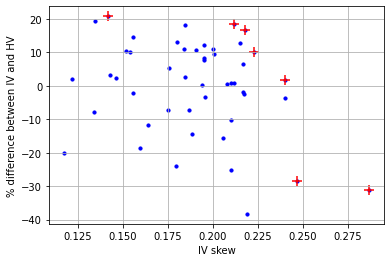

[[array(['(ULTA)', 'consumer_cyclical'], dtype='<U25') 0.2868
  -31.090821720326765]
 [array(['(WFC)', 'financials'], dtype='<U25') 0.2468 -28.380731282646554]
 [array(['(LULU)', 'consumer_cyclical'], dtype='<U25') 0.2404
  -3.763010408326658]
 [array(['(C)', 'financials'], dtype='<U25') 0.2228 10.024691358024683]
 [array(['(ROST)', 'consumer_cyclical'], dtype='<U25') 0.2182
  16.746923488496517]
 [array(['(TJX)', 'consumer_cyclical'], dtype='<U25') 0.2116
  18.54341736694679]
 [array(['(MDLZ)', 'consumer_staple'], dtype='<U25') 0.1421
  20.83333333333334]]


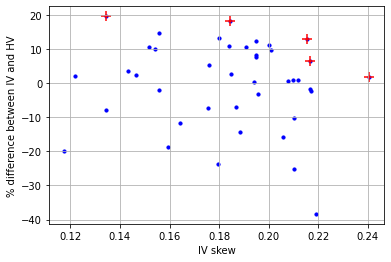

[[array(['(MS)', 'financials'], dtype='<U25') 0.2404 1.649048625792818]
 [array(['(ADI)', 'technology'], dtype='<U25') 0.2168 6.535626535626539]
 [array(['(DLTR)', 'consumer_staple'], dtype='<U25') 0.2153
  12.84067085953878]
 [array(['(CPB)', 'consumer_staple'], dtype='<U25') 0.1844
  18.20512820512821]
 [array(['(PG)', 'consumer_staple'], dtype='<U25') 0.1345
  19.55555555555556]]


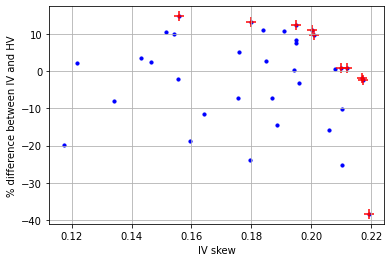

[[array(['(DPZ)', 'consumer_cyclical'], dtype='<U25') 0.2192
  -38.32301631963984]
 [array(['(ABC)', 'healthcare'], dtype='<U25') 0.2172 -2.2941970310391335]
 [array(['(KR)', 'consumer_staple'], dtype='<U25') 0.2168
  -1.8560434585785515]
 [array(['(SYY)', 'consumer_staple'], dtype='<U25') 0.212
  0.8563273073263539]
 [array(['(HUM)', 'healthcare'], dtype='<U25') 0.21 0.8645533141210356]
 [array(['(ADBE)', 'technology'], dtype='<U25') 0.201 9.65630114566286]
 [array(['(CRM)', 'technology'], dtype='<U25') 0.2002 11.098779134295222]
 [array(['(INTU)', 'technology'], dtype='<U25') 0.195 12.262521588946468]
 [array(['(AVGO)', 'technology'], dtype='<U25') 0.18 13.065326633165819]
 [array(['(STZ)', 'consumer_staple'], dtype='<U25') 0.1559
  14.716703458425325]]


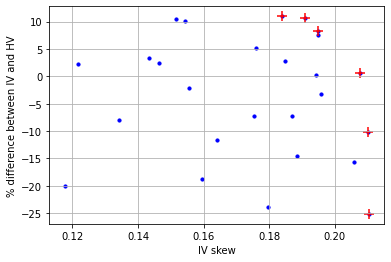

[[array(['(ANTM)', 'healthcare'], dtype='<U25') 0.2104
  -25.124555160142354]
 [array(['(GS)', 'financials'], dtype='<U25') 0.2102 -10.094097519247223]
 [array(['(AMGN)', 'healthcare'], dtype='<U25') 0.2078 0.580832526621494]
 [array(['(TSM)', 'technology'], dtype='<U25') 0.195 8.213096559378473]
 [array(['(MDT)', 'healthcare'], dtype='<U25') 0.191 10.660486674391656]
 [array(['(ORCL)', 'technology'], dtype='<U25') 0.184 10.977080820265376]]


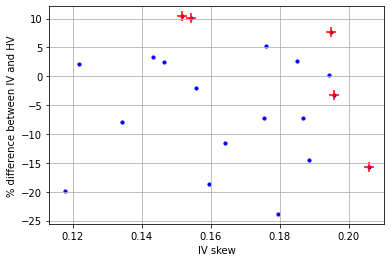

[[array(['(PNC)', 'financials'], dtype='<U25') 0.2059 -15.683865683865683]
 [array(['(ETN)', 'industrials'], dtype='<U25') 0.1958 -3.213049925852697]
 [array(['(JCI)', 'industrials'], dtype='<U25') 0.195 7.615894039735103]
 [array(['(CSCO)', 'technology'], dtype='<U25') 0.1542 10.064239828693792]
 [array(['(HD)', 'consumer_cyclical'], dtype='<U25') 0.1516
  10.41514930808449]]


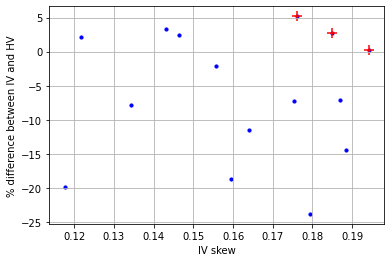

[[array(['(EMR)', 'industrials'], dtype='<U25') 0.1942
  0.20639834881321542]
 [array(['(NKE)', 'consumer_cyclical'], dtype='<U25') 0.1849
  2.722222222222231]
 [array(['(PM)', 'consumer_staple'], dtype='<U25') 0.176
  5.200239091452471]]


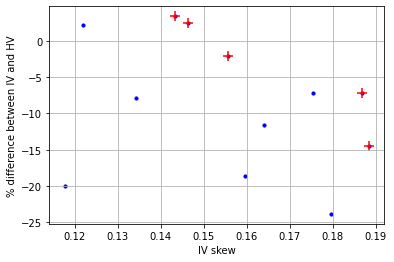

[[array(['(USB)', 'financials'], dtype='<U25') 0.1884 -14.480254198819784]
 [array(['(BLK)', 'financials'], dtype='<U25') 0.1869 -7.153502235469446]
 [array(['(COST)', 'consumer_staple'], dtype='<U25') 0.1556
  -2.0767778477029735]
 [array(['(DG)', 'consumer_staple'], dtype='<U25') 0.1464
  2.449265220433872]
 [array(['(ACN)', 'technology'], dtype='<U25') 0.1432 3.393501805054138]]


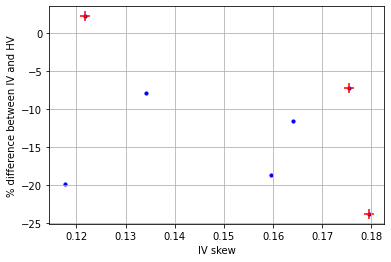

[[array(['(TGT)', 'consumer_staple'], dtype='<U25') 0.1795
  -23.84386932541366]
 [array(['(JPM)', 'financials'], dtype='<U25') 0.1754 -7.244843997884712]
 [array(['(PEP)', 'consumer_staple'], dtype='<U25') 0.1218
  2.1812080536912792]]


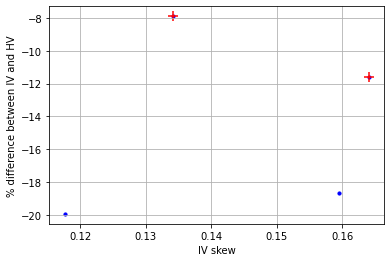

[[array(['(ED)', 'utilities'], dtype='<U25') 0.1641 -11.584051724137927]
 [array(['(JNJ)', 'healthcare'], dtype='<U25') 0.1342 -7.8929306794783685]]


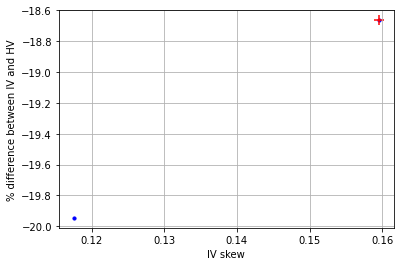

[[array(['(UNH)', 'healthcare'], dtype='<U25') 0.1595 -18.663946965833755]]


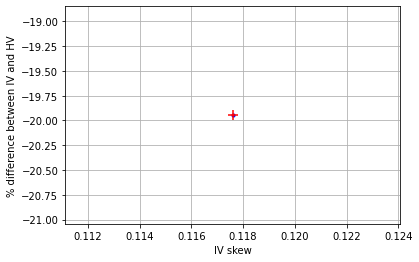

[[array(['(VZ)', 'communications'], dtype='<U25') 0.1176
  -19.945541184479243]]


In [15]:
while stock_info_with_iv.shape[0] > 0:

    indices = get_front(iv_data)
    
    print(stock_info_with_iv[indices][:, [0, 1, 3]])
    
    stock_info_with_iv = np.delete(stock_info_with_iv, indices, 0)
    iv_data = np.delete(iv_data, indices, 0)

# gamma vs delta analysis

In [43]:
def compute_accumulated_delta(n, gamma, delta):
    
    accumulated_delta = n*delta + 0.5*gamma*(n-1)*n
    
    return accumulated_delta

In [147]:
# query 1

n = 10
gamma = 0.1
delta = 0.6

In [148]:
accumulated_delta = compute_accumulated_delta(n, gamma, delta)

In [149]:
print(accumulated_delta)

10.5


In [58]:
# query 2

n = 2
gamma = 0.1
delta = 0.5

In [59]:
accumulated_delta = compute_accumulated_delta(n, gamma, delta)

In [60]:
print(accumulated_delta)

1.0
